Epoch 1: loss = 0.8439
Epoch 2: loss = 0.7431
Epoch 3: loss = 0.6654
Epoch 4: loss = 0.6129
Epoch 5: loss = 0.5824
Epoch 6: loss = 0.5571
Epoch 7: loss = 0.5309
Epoch 8: loss = 0.5033
Epoch 9: loss = 0.4700
Epoch 10: loss = 0.4350
Epoch 11: loss = 0.4037
Epoch 12: loss = 0.3748
Epoch 13: loss = 0.3451
Epoch 14: loss = 0.3184
Epoch 15: loss = 0.2952
Epoch 16: loss = 0.2754
Epoch 17: loss = 0.2627
Epoch 18: loss = 0.2496
Epoch 19: loss = 0.2318
Epoch 20: loss = 0.2168
Epoch 21: loss = 0.2062
Epoch 22: loss = 0.1927
Epoch 23: loss = 0.1778
Epoch 24: loss = 0.1640
Epoch 25: loss = 0.1519
Epoch 26: loss = 0.1406
Epoch 27: loss = 0.1287
Epoch 28: loss = 0.1172
Epoch 29: loss = 0.1078
Epoch 30: loss = 0.0998


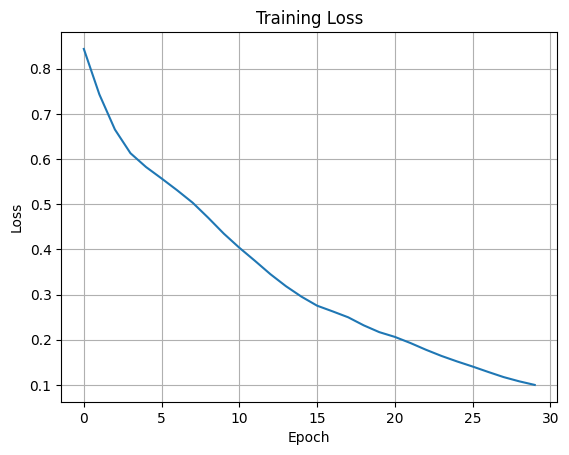


Test Predictions:
Input: [0.0, 0.0] → Predicted: 0.027 (Expected: 0.0)
Input: [0.0, 1.0] → Predicted: 0.049 (Expected: 0.0)
Input: [1.0, 0.0] → Predicted: 0.030 (Expected: 0.0)
Input: [1.0, 1.0] → Predicted: 0.773 (Expected: 1.0)


In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ---- Data (AND logic gate) ----
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
Y = torch.tensor([[0], [0], [0], [1]], dtype=torch.float32)

# ---- Quantum Circuit ----
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Encode classical data
    for i in range(n_qubits):
        qml.RY(np.pi * inputs[i], wires=i)
    
    # Simple entanglement
    qml.CNOT(wires=[0, 1])

    # Variational layer
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)

    return qml.expval(qml.PauliZ(0))

# ---- Hybrid Quantum-Classical Layer ----
class HybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = nn.Linear(2, 2)          # Classical preprocessing
        self.q_params = nn.Parameter(torch.randn(2) * 0.01)  # Quantum trainable weights
        self.clayer_2 = nn.Linear(1, 1)          # Post-quantum layer

    def forward(self, x):
        x = self.clayer_1(x)
        x = torch.tanh(x)
        q_out = torch.stack([quantum_circuit(x[i], self.q_params) for i in range(len(x))])
        q_out = q_out.unsqueeze(1).float()  # Convert to float32
        x = self.clayer_2(q_out)
        x = torch.sigmoid(x)
        return x


# ---- Training ----
model = HybridQNN()
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.BCELoss()

losses = []

for epoch in range(30):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, Y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")

# ---- Plotting ----
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

# ---- Test Output ----
print("\nTest Predictions:")
with torch.no_grad():
    for i in range(len(X)):
        pred = model(X[i].unsqueeze(0))
        print(f"Input: {X[i].tolist()} → Predicted: {pred.item():.3f} (Expected: {Y[i].item()})")